In [59]:
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
from imutils import perspective
from imutils import contours
import numpy as np
import cv2

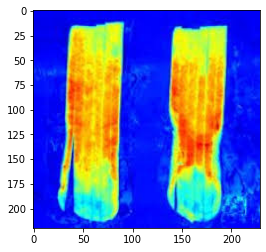

In [60]:
img = cv2.imread(rf"sample.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

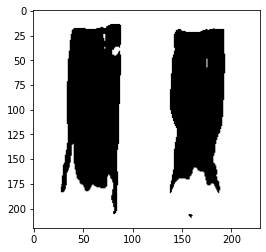

In [61]:

HSVimg = cv2.fastNlMeansDenoisingColored(img, h = 20,templateWindowSize = 7 ,searchWindowSize = 21)
HSVimg = cv2.cvtColor(HSVimg, cv2.COLOR_BGR2HSV_FULL)

lower_range = np.array([70, 0, 0])#Need to edit
upper_range = np.array([255, 255, 255])#Need to edit

color_mask = cv2.inRange(HSVimg, lower_range, upper_range)

edited_image = cv2.bitwise_and(HSVimg, HSVimg, mask=color_mask)
edited_image = cv2.cvtColor(edited_image, cv2.COLOR_HSV2BGR_FULL)

plt.imshow(edited_image)

filteredimg = edited_image

height, width, _ = edited_image.shape

for i in range(height):
    for j in range(width):
        # img[i,j] is the RGB pixel at position (i, j)
        # check if it's [0, 0, 0] and replace with [255, 255, 255] if so
        if edited_image[i, j].sum() == 0:
            if 1:
                edited_image[i, j] = [0, 0, 0]
            else:
                edited_image[i, j] = [255, 255, 255]
        else:
            if 1:
                edited_image[i, j] = [255, 255, 255]
            else:
                edited_image[i, j] = [0, 0, 0]

plt.imshow(edited_image)

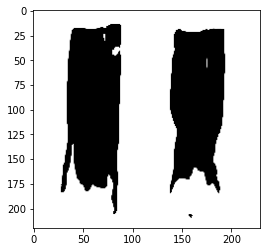

In [62]:

streak_removed_img = edited_image.copy()
for i in range(0, 3):
        streak_removed_img = cv2.fastNlMeansDenoising(streak_removed_img, h = 20,templateWindowSize = 7 ,searchWindowSize = 21)

'''element = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
streak_removed_img = cv2.erode(streak_removed_img, element, iterations=1)
streak_removed_img = cv2.dilate(streak_removed_img, element, iterations=1)
#streak_removed_img = cv2.erode(streak_removed_img, element)'''

plt.imshow(streak_removed_img)


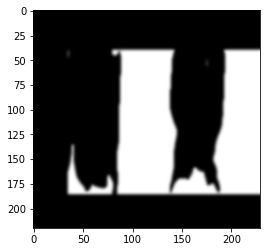

In [63]:
#ROI - TO IGNORE DETECTION FOR PART OF THE IMAGE
black = np.zeros((img.shape[0], img.shape[1], 3), np.uint8) #---black in RGB
black1 = cv2.rectangle(black,(35,40),(img.shape[1],img.shape[0]-35),(255, 255, 255), -1)   #---the dimension of the ROI
roi_gray = cv2.cvtColor(black1,cv2.COLOR_BGR2GRAY)               #---converting to gray
ret,roimask = cv2.threshold(roi_gray,127,255, 0)                 #---converting to binary image

ROI_Img = cv2.bitwise_and(streak_removed_img,streak_removed_img,mask = roimask)
gray = cv2.GaussianBlur(ROI_Img, (7, 7), 0)
gray = cv2.fastNlMeansDenoising(gray, h = 20,templateWindowSize = 7 ,searchWindowSize = 21)


plt.imshow(gray)


True

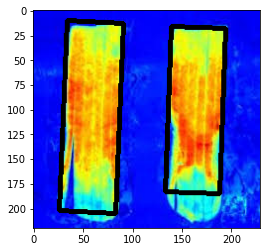

In [64]:
# load the image, convert it to grayscale, and blur it slightly

# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges

#NO ROI
edged = cv2.Canny(streak_removed_img, 50, 100)

#ROI
#edged = cv2.Canny(gray, 50, 100)

edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

# find contours in the edge map
cnts, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
#cnts = imutils.grab_contours(cnts)

try: hierarchy = hierarchy[0]
except: hierarchy = []

height, width = edged.shape
min_x, min_y = width, height
max_x = max_y = 0

predicted = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2BGR)
predicted_cnts = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2BGR)

'''for contour, hier in zip(cnts, hierarchy):
    (x,y,w,h) = cv2.boundingRect(contour)
    min_x, max_x = min(x, min_x), max(x+w, max_x)
    min_y, max_y = min(y, min_y), max(y+h, max_y)
'''
for count in range(0,len(cnts)):
    (x,y,w,h) = cv2.boundingRect(cnts[count])
    min_x, max_x = min(x, min_x), max(x+w, max_x)
    min_y, max_y = min(y, min_y), max(y+h, max_y)
    if (w > 5 and h > 5):

        rect = cv2.minAreaRect(cnts[count]) # basically you can feed this rect into your classifier
        (x,y),(w,h), a = rect # a - angle
        box = cv2.boxPoints(rect)
        box = np.int0(box) #turn into ints
        predicted = cv2.drawContours(predicted.copy(),[box],0,(0,0,0),3)
        #cv2.rectangle(predicted, (x,y), (x+w,y+h), (0, 0, 0), 3)

cv2.drawContours(predicted_cnts, cnts, -1, (0, 0, 0), 3)

plt.imshow(predicted)


predicted = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)
predicted_cnts = cv2.cvtColor(predicted_cnts, cv2.COLOR_BGR2RGB)

cv2.imwrite(fr"sample_output.png", predicted)

#vis = np.concatenate((img, filteredimg, predicted), axis=0)

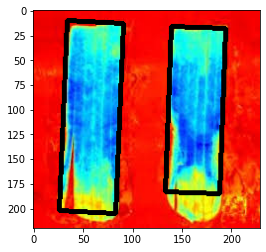

In [65]:
plt.imshow(predicted)

# cv2.imwrite(fr"sample_output.png", predicted)

#vis = np.concatenate((img, filteredimg, predicted), axis=0)


True

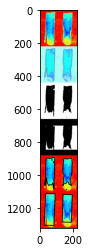

In [66]:
vis = np.concatenate((img, HSVimg, filteredimg, ROI_Img, predicted_cnts, predicted), axis=0)
plt.imshow(vis)

cv2.imwrite(fr"sample_all.png", vis)

